In [1]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import sys, os
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.join(os.path.abspath(''),'..','scripts'))
sys.path.append(os.path.join(os.path.abspath(''),'..','src'))


from scipy.stats import entropy
from scipy.interpolate import CubicSpline
from numpy.linalg import norm
import numpy as np
from sklearn.metrics import r2_score

def get_all_fake_values(y, x, n):
    cs = CubicSpline(x, y, extrapolate=True)
    return np.array(cs(range(int(n))))

def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _P[_P <= 0] = 1
    _Q[_Q <= 0] = 1
    
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

def rel_diff(true_y, false_y):
    return r2_score(true_y, false_y)

def get_adversary_sequences(df):
    listdic = df
    d = {}
    for el in listdic:
        if el == None:
            continue
        for sname in el:
            if sname not in d:
                d[sname] = []
            d[sname].append(el[sname])
    return d

from Experiment import *
from Analyzer import *

In [2]:
brightkite = Analyzer("brightkite").df

In [3]:
brightkite.iloc[0]['n'], brightkite.iloc[0]['m']

(56740.0, 212945.0)

In [4]:
advogato = Analyzer("advogato").df

In [5]:
gnutella = Analyzer("gnutella").df

In [6]:
stanford = Analyzer("stanford").df

In [7]:
dblp = Analyzer("dblp").df
dblp = dblp[dblp['weight_scale'] == 0.5]

In [80]:
data = pd.DataFrame()

# for dd, nname in [(advogato, "Advogato"), (brightkite, "Brightkite"), (dblp, "DBLP"), (gnutella, "Gnutella"), (stanford, "Stanford")]:
for dd, nname in [(advogato, "Advog"), (brightkite, "Brigh"), (dblp, "DBLP"), (gnutella, "Gnut"), (stanford, "Stanf")]:
    df = dd[dd['mode'] == 5]
    imm = df['Total imm time'].sum()/3600
    data = data.append({"Runtime [h]": imm, 
                        "Measure": "SEMF",
                        "Network": nname,
                        "Immunization": 0}, ignore_index=True)
    data = data.append({"Runtime [h]": df['runtime'].sum()/(3600*10**9), 
                        "Measure": "SEMF",
                        "Network": nname,
                        "Immunization": 1}, ignore_index=True)
    
    df = dd[dd['mode'] == 0]
    data = data.append({"Runtime [h]": imm, "Measure": "SRNI", "Network": nname,
                        "Immunization": 0}, ignore_index=True)
    data = data.append({"Runtime [h]": df['runtime'].sum()/(3600*10**9), "Measure": "SRNI", "Network": nname,
                        "Immunization": 1}, ignore_index=True)
    
    df = dd[dd['mode'].isna()]
    data = data.append({"Runtime [h]": imm, "Measure": "SRIM", "Network": nname,
                        "Immunization": 0}, ignore_index=True)
    data = data.append({"Runtime [h]": df['runtime'].sum()/(3600*10**9), "Measure": "SRIM", "Network": nname,
                        "Immunization": 1}, ignore_index=True)

In [81]:
data.set_index(["Measure", "Network", "Immunization"], inplace=True)
data["vcs"] = data.groupby(level=["Measure", "Network"]).cumsum()
data.reset_index(inplace=True) 

Text(0, 0.5, 'Runtime [h]')

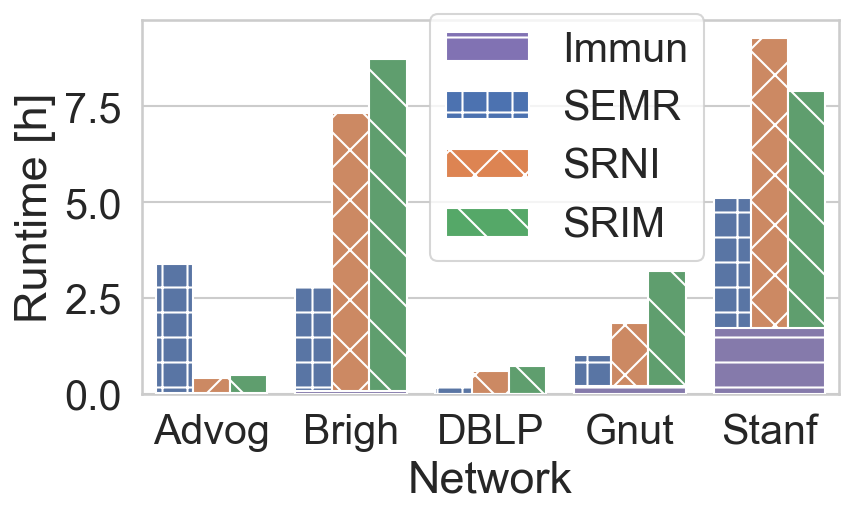

In [91]:
c = sns.color_palette("deep")
# sns.set_context(context="paper", font_scale=1.4, rc={'axes.grid': True})
# sns.set_style("whitegrid")
# fig = plt.figure(figsize=(5.6,3), dpi=120)
# ax = fig.add_subplot(1, 1, 1)

hatches = ['-', '+', 'x', '\\']

fig = plt.figure(figsize=(6, 3.3), dpi=150)
sns.set(style="whitegrid", font_scale=1.8, rc={'axes.grid': True})
ax = fig.add_subplot(1, 1, 1)


for i, g in enumerate(data.groupby("Immunization")):
    if i == 0:
        ax = sns.barplot(data=g[1],
                         x="Network",
                         y="vcs",
                         color=c[4],
                         zorder=20-i, ax=ax)
        # this is just to "lift" bars
    else:
        ax = sns.barplot(data=g[1],
                         x="Network",
                         y="vcs",
                         palette = c,
                         hue="Measure",
                         zorder=20-i, ax=ax)

        for jj,thisbar in enumerate(ax.patches):
            # Set a different hatch for each bar
            thisbar.set_hatch(hatches[(jj // 5) % 4])
#             if jj < 5:
#                 thisbar.set_hatch(hatches[3])
#             else:
#                 thisbar.set_hatch(hatches[(jj-5) % 2])

        
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(facecolor=c[4], label='Immun', hatch='-')
red_patch1 = mpatches.Patch(facecolor=c[0], label='SEMR', hatch='+')
red_patch2 = mpatches.Patch(facecolor=c[1], label='SRNI', hatch='x')
red_patch3 = mpatches.Patch(facecolor=c[2], label='SRIM', hatch='\\')
plt.legend(handles=[red_patch,red_patch1,red_patch2,red_patch3], bbox_to_anchor=(0.61,0.3))

plt.ylabel("Runtime [h]")
# ax.legend_.remove() # remove the redundant legends 

In [99]:
data = pd.DataFrame()
# for dd, nname in [(advogato, "Advogato"), (brightkite, "Brightkite"), (dblp, "DBLP"), (gnutella, "Gnutella"), (stanford, "Stanford")]:
for dd, nname in [(advogato, "Advog"), (brightkite, "Brigh"), (dblp, "DBLP"), (gnutella, "Gnut"), (stanford, "Stanf")]:
    
    df = dd[dd['mode'] == 5]
    seq = []
    for s in df.solver.unique():
        fake_values = df[df['solver'] == s].iloc[0]['sequence']
        fake_x = df.iloc[0]['samples_blocked_values']
        fake_all = get_all_fake_values(fake_values, fake_x, df.iloc[0]['n'])
        seq.append(fake_all)
    seq1 = np.amin(np.array(seq), axis=0)
    assert(len(seq1) == df.iloc[0]['n'])
    data = data.append({"Sum / n": np.sum(seq1)/(df.iloc[0]['n'])**2, "Measure": "SEMR", "Network": nname}, ignore_index=True)
    
    df = dd[dd['mode'] == 0]
    seq = []
    for s in df.solver.unique():
        fake_values = df[df['solver'] == s].iloc[0]['sequence']
        fake_x = df.iloc[0]['samples_blocked_values']
        fake_all = get_all_fake_values(fake_values, fake_x, df.iloc[0]['n'])
        seq.append(fake_all)
    seq2 = np.amin(np.array(seq), axis=0)
    data = data.append({"Sum / n": np.sum(seq2)/(df.iloc[0]['n'])**2, "Measure": "SRNI", "Network": nname}, ignore_index=True)
#     data = data.append({"Relative Value": np.sum(seq1-seq2)/(df.iloc[0]['n'])**2, "Measure": "D", "Network": nname}, ignore_index=True)
    
    
    df = dd[dd['mode'].isna()]
    seq = []
    if len(df) == 0:
        continue
    d = get_adversary_sequences(df.iloc[0]['objective_per_adversary'])
    for s in d:
        fake_values = d[s]
        fake_x = df.iloc[0]['samples_blocked_values']
        fake_all = get_all_fake_values(fake_values, fake_x, df.iloc[0]['n'])
        seq.append(fake_all)
    seq2 = np.amin(np.array(seq), axis=0)
    data = data.append({"Sum / n": np.sum(seq2)/(df.iloc[0]['n']), "Measure": "SRIM", "Network": nname}, ignore_index=True)
    

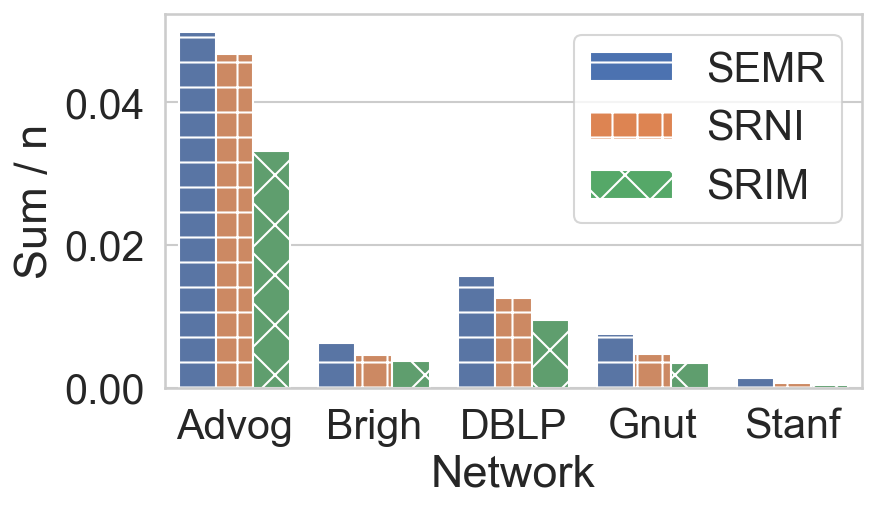

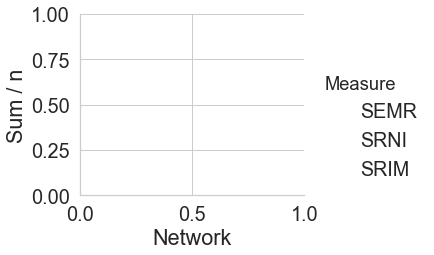

In [105]:
fig = plt.figure(figsize=(6, 3.3), dpi=150)
sns.set(style="whitegrid", font_scale=1.8, rc={'axes.grid': True})
ax = fig.add_subplot(1, 1, 1)
sns.catplot(x="Network", y="Sum / n", hue="Measure", kind="bar", height=4, aspect=1.2, data=data, ax=ax, palette="deep")

for jj,thisbar in enumerate(ax.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[(jj // 5) % 4])

red_patch1 = mpatches.Patch(facecolor=c[0], label='SEMR', hatch='-')
red_patch2 = mpatches.Patch(facecolor=c[1], label='SRNI', hatch='+')
red_patch3 = mpatches.Patch(facecolor=c[2], label='SRIM', hatch='x')
ax.legend(handles=[red_patch1,red_patch2,red_patch3])